In [1]:
import pprint
from tqdm.notebook import trange, tqdm

pp = pprint.PrettyPrinter()

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim

class FederatedManager:

    def __init__(self, 
                 name,
                 dataloaders, 
                 test,
                 make_model,
                 loss_fn=nn.CrossEntropyLoss(), 
                 n_epochs=1, 
                 lr=1e-2, 
                 verbose=False, 
                 *args, **kwargs):
        
        self.dataloaders = dataloaders
        self.n_workers = len(dataloaders)
        self.n_epochs = n_epochs
        self.lr = lr
        self.verbose = verbose
        self.name = name
        self.history = {"test_loss": [], "test_acc": []}
        self.make_model = make_model
        self.model = self.make_model()
        self.model.train(False)
        self.loss_fn = loss_fn
        self.Xtest, self.ytest = consume_dataset(test)
        self.workers = []
        for i, dl in enumerate(dataloaders):
            self.workers.append(FederatedWorker(i, 
                                                self, 
                                                dl, 
                                                loss_fn,
                                                n_epochs=n_epochs, 
                                                lr=lr, 
                                                verbose=verbose,
                                                *args,
                                                **kwargs))
        self.worker_loss_histories = [[] for _ in self.workers]

    def round(self):
        """
        Do a round of federated learning:
         - instruct each worker to train and return its model
         - replace the server model the weighted average of the worker models
         - replace the worker models with the server model
        Workers with `participant=False` train but are not included in the
        weighted average and do not receive a copy of the server model.
        """
        updates = [w.train() for w in self.workers]
        self.fedavg(
            [u for u, w in zip(updates, self.workers) if w.participant]
        )
        self.push_model(w for w in self.workers if w.participant)
        self.record_loss()

    def fedavg(self, updates):
        """
        Replace the manager model with the weighted average of the node models.
        """
        N = sum(u["n_samples"] for u in updates)
        for key, value in self.model.state_dict().items():
            weight_sum = (
                u["state_dict"][key] * u["n_samples"] for u in updates
            )
            value[:] = sum(weight_sum) / N

    def push_model(self, workers):
        """
        Push manager model to a list of workers.
        """
        for worker in workers:
            worker.model = self.copy_model()

    def copy_model(self):
        """
        Return a copy of the current manager model.
        """
        model_copy = self.make_model()
        model_copy.load_state_dict(self.model.state_dict())
        return model_copy

    def evaluate_model(self, model=None):
        """
        Compute the loss and accuracy of model on test set.
        """
        model = model or self.model
        
        model = model.to('cuda')
        
        was_training = model.training
        model.train(False)
        with torch.no_grad():
            
            self.Xtest = self.Xtest.to('cuda')
            self.ytest = self.ytest.to('cuda')
            
            output = model(self.Xtest)
            
            output = output.to('cuda')
            
            loss = self.loss_fn(output, self.ytest).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct = pred.eq(self.ytest.view_as(pred)).sum().item()
        model.train(was_training)
        return loss, 100. * correct / len(self.ytest)

    def record_loss(self):
        """
        Record loss of manager model and all worker models on test set.
        """
        loss_accuracy = self.evaluate_model()
        self.history["test_loss"].append(loss_accuracy[0])
        self.history["test_acc"].append(loss_accuracy[1])

In [3]:
class FederatedWorker:

    def __init__(
        self, name, manager, dataloader, loss_fn, n_epochs=1, lr=1e-2,
        momentum=0.5, participant=True, verbose=False
    ):
        self.name = name
        self.manager = manager
        self.dataloader = dataloader
        self.n_epochs = n_epochs
        self.loss_fn = loss_fn
        self.participant = participant
        self.model = manager.copy_model()
        self.n_samples = len(self.dataloader.dataset)
        self.history = {"train_loss": [], "test_loss": [], "test_acc": []}
        self.lr = lr
        self.momentum = momentum
        self.verbose = verbose

    def train(self):
        """
        Train for n_epochs, then return the state dictionary of the model and
        the amount of training data used.
        """
        
        self.model = self.model.to('cuda')
        
        optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr,
                                    momentum=self.momentum)
        self.model.train(True)
        for epoch in range(self.n_epochs):
            for i, (x, y) in enumerate(self.dataloader):
                
                x = x.to('cuda')
                y = y.to('cuda')
                
                optimizer.zero_grad()
                ypred = self.model(x)
                train_loss = self.loss_fn(ypred, y)
                train_loss.backward()
                optimizer.step()
                self.history["train_loss"].append(train_loss.item())

        loss_accuracy = self.manager.evaluate_model(self.model)
        self.history["test_loss"].append(loss_accuracy[0])
        self.history["test_acc"].append(loss_accuracy[1])
        
        if(self.verbose):
            print(
                '\twrkr {}\t\tloss: {:.4f} ({:+.4f})\tacc: {:6.2%} ({:+7.2%})\tmodel:{}'.format(
                    self.name,
                    self.history["test_loss"][-1],
                    self.history["test_loss"][-1] - self.history["test_loss"][max(-2, -(len(self.history["test_loss"])))],
                    self.history["test_acc"][-1] / 100,
                    (self.history["test_acc"][-1] - self.history["test_acc"][max(-2, -(len(self.history["test_acc"])))]) / 100,
                    str(id(self.model))[-5:],
                )
            )

        return {
            "state_dict": self.model.state_dict(),
            "n_samples": self.n_samples
        }

In [27]:
  

# THIS IS THE OFFICIAL PYTORCH EXAMPLE, BUT IT'S SLOWER THAN THE OTHER MODEL, SO FOR NOW, IT'S FAST BEFORE TIDY
'''
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
'''

# Quick and gets the job done well enough for testing
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
#'''

In [111]:
from torch.utils.data import Subset

def make_fed_dloaders(dset, p=None, batch_size=64, shuffle=True):
    
    return [DataLoader(dset, batch_size, shuffle) for dset in make_fed_dsets(dset, p=p)]
    
def make_fed_dsets(dset, p=None):
    _, y = consume_dataset(dset)
    classes = set(y.numpy())
    n_classes = len(classes)
    idx_dset = index_to_dataset(y, p=p)
    dset_idx = [np.where(idx_dset == di)[0] for di in range(n_classes)]
    return [Subset(dset, di) for di in dset_idx]

def index_to_dataset(y, p=None):
    classes = set(y.numpy())
    n_classes = len(classes)
    p = p or 1/n_classes
    pnot = (1-p)/(n_classes-1)
    ps = np.full((n_classes, n_classes), pnot)
    np.fill_diagonal(ps, p)
    return np.array([np.random.choice(10, p=ps[yi]) for yi in y])

def check_dsets(dsets):
    for i, dset in dsets:
        _, y = consume_dataset(dset)
        print('worker', i, ':', Counter(y.numpy()))

def eval_new_mgr(name, train_dset, test_dset, p=0.0, n_rounds=50, target_acc=None, net=Net):
    dls = make_fed_dloaders(train_dset, p=p)
    mgr = FederatedManager(name, dls, test_dset, net)
    run_mgr(mgr, n_rounds, target_acc)
    plot_mgr(mgr)
    return mgr

In [6]:
#%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tqdm.notebook import trange
from collections import Counter
import numpy as np

def plot_digit_histogram(dls, title=''):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.set_ylabel('Digit Samples')
    ax.set_xlabel('Digit')
    
    ys = []
    for dset in tqdm([dl.dataset for dl in dls], desc='Tabulating datasets'):
        _, y = consume_dataset(dset)
        ys.append(sorted(Counter(y)))
        
    H = ax.hist(ys, bins=range(11), histtype='bar', align='left', rwidth=0.8)

def consume_dataset(dataset):
    data = list(zip(*dataset))
    X = torch.stack(data[0])
    y = torch.tensor(data[1])
    return X, y

In [7]:
def run_mgr(mgr, n_rounds=10, target_acc=None):
    
    target_met = False;
    
    if (target_acc):
        print('{} manager training with {} worker(s) for up to {} rounds or {:.2%} accuracy.'.format(
                mgr.name, mgr.n_workers, n_rounds, target_acc / 100,))
    else:
        print('{} manager training with {} worker(s) for {} rounds.'.format(
                mgr.name, mgr.n_workers, n_rounds,))

    for i in trange(n_rounds, desc='Rounds'):
        if(mgr.verbose):
            print('Round', i)
        mgr.round()
        if(mgr.verbose):
            print('\tcombined\tloss: {:.4f}\tacc: {:.2%}\n'.format(
                mgr.history['test_loss'][-1], mgr.history['test_acc'][-1] / 100,))
            
        if(target_acc and (mgr.history['test_acc'][-1] >= target_acc)):
            target_met = True
            break;

    if(target_met):
        print('{} manager stopped: met accuracy target of {:.2%} after {} rounds. (Test accuracy {:.2%} and loss {:.4f}.)'.format(
                mgr.name, target_acc / 100, len(mgr.history['test_acc']), mgr.history['test_acc'][-1] / 100, mgr.history['test_loss'][-1],))
    else:
        print('{} manager trained {} rounds. (Test accuracy {:.2%} and loss {:.4f}.)'.format(
                mgr.name, len(mgr.history['test_acc']), mgr.history['test_acc'][-1] / 100, mgr.history['test_loss'][-1],))

def plot_mgr(mgrs, plot_workers=False):
    
    if not isinstance(mgrs, list):
        mgrs = [mgrs]
    
    fig, ax = plt.subplots()
    for m in mgrs:
        ax.plot(m.history['test_loss'], label=m.name)
        if(plot_workers):
            for w in m.workers:
                ax.plot(w.history['test_loss'], label=(m.name, 'Worker ' + str(w.name)))
    ax.set_xlabel("Round")
    ax.set_ylabel("Loss")
    ax.legend();
    
    fig, ax = plt.subplots()
    for m in mgrs:
        ax.plot(m.history['test_acc'], label=m.name)
        if(plot_workers):
            for w in m.workers:
                ax.plot(w.history['test_acc'], label=(m.name, 'worker ' + str(w.name)))
    ax.set_xlabel("Round")
    ax.set_ylabel("Accuracy")
    ax.legend();

    

In [43]:
def get_eval_set(model, examples, targets):
    with torch.no_grad():
        model = model.cpu()
        examples = examples.cpu()
        targets = targets.cpu()
        output = model(examples)
    preds = output.argmax(dim=1, keepdim=True)
    return [{'x':examples[i],
             'probs':output[i],
             'pred':preds[i].item(),
             'y':targets[i].item(),
             } for i in range(len(examples))]

def confusion_matrix(eval_set, norm=False, mirror=False):
    cm = np.zeros((10, 10))
    for ev in eval_set:
        cm[ev['y']][ev['pred']] += 1
        if mirror:
            cm[ev['pred']][ev['y']] += 1 # will amplify errors and remove directionality of error
    if norm:
        cm /= cm.sum(axis=1)[:,np.newaxis]
    return cm

def show_model_confusion(manager, show_manager=True, show_workers=False):
    
    examples, targets = manager.Xtest, manager.ytest
    
    model = manager.model
    
    eval_set = get_eval_set(model, examples, targets)
    misses = [ev for ev in eval_set if (ev['y'] != ev['pred'])]
    cm = confusion_matrix(misses, norm=False, mirror=True)
    #cm = np.log1p(cm)
    #print(np.array_str(cm, precision=4, suppress_small=True))
    plt.imshow(cm)
    plt.tight_layout()
    
    if show_workers:
        
        for worker in manager.workers()
        
        #plot the workers
    
def count_dsets(dsets, show_array=False, show_heatmap=False, classes=10):
    cts = []
    for dset in tqdm(dsets, desc='Counting examples'):
        _, y = consume_dataset(dset)
        c = Counter(y.numpy())
        #print([c[i] for i in range(len(c))])
        
        #if(len(c) < classes):
            #add those zeros
        
        cts.append([c[i] for i in range(classes)])
    
    
    cts = np.array(cts)
    
    if show_array:
        print(cts)
        
    if show_heatmap:
        cts_log1p = np.log1p(cts)
        cts_sum_lpg1p = np.log1p(cts.sum())
        plt.imshow(cts_log1p, norm=plt.Normalize(vmin= 0.0, vmax=cts_sum_lpg1p));
        plt.tight_layout();
        
    return np.array(cts)

def show_prediction(img, preds, correct_idx, size=7, limit=15):
    
    preds = preds.data.numpy().squeeze() 
    
    # center the values around 0 by averaging min and max
    preds_centered = preds + ((preds.max() + preds.min()) / 2)
    
    colors = ['blue'] * len(preds)
    colors[preds.argmax()] = 'red'
    colors[correct_idx] = 'green'

    fig, (ax1, ax2) = plt.subplots(figsize=(size , size*1.5), ncols=2)

    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())

    ax2.bar(range(10), preds_centered, color=colors)
    ax2.set_aspect(0.542)
    ax2.set_xticks(range(10))
    ax2.set_xticklabels(range(10))
    ax2.set_xlabel('digit')
    ax2.set_ylabel('log(p) centered on average')
    ax2.set_ylim(-limit, limit)
    ax2.set_aspect(10.84/abs(ax2.get_ylim()[0] - ax2.get_ylim()[1]))
    plt.tight_layout()

# Common Data and Hyperparameters

In [9]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms

data_path = './MNIST-data/raw'

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dset = dsets.MNIST(root=data_path, download=True, train=True, transform=trans)
test_dset = dsets.MNIST(root=data_path, download=True, train=False, transform=trans)

In [10]:
from torch.utils.data import DataLoader

train_batch_size = 256
test_batch_size = 1000

# create standard dataloaders using all of the MNIST data
train_dl = DataLoader(train_dset, batch_size=train_batch_size, shuffle=True)
test_dl = DataLoader(test_dset, batch_size=test_batch_size, shuffle=True)

In [11]:
# default training targets
default_n_rounds = 50
default_target_acc = None

# Non-Federated

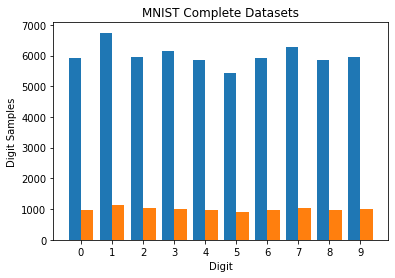

In [12]:
plot_digit_histogram([train_dl, test_dl], 'MNIST Complete Datasets')


[[5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]]


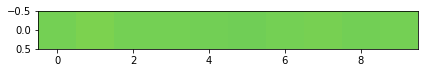

In [13]:
train_counts = count_dsets([train_dl.dataset], show_array=True, show_heatmap=True)

Non-Federated Full Dataset manager training with 1 worker(s) for 50 rounds.


Round 0
	wrkr 0		loss: 0.2527 (+0.0000)	acc: 92.48% ( +0.00%)	model:27184
	combined	loss: 0.2527	acc: 92.48%

Round 1
	wrkr 0		loss: 0.1793 (-0.0734)	acc: 94.70% ( +2.22%)	model:20048
	combined	loss: 0.1793	acc: 94.70%

Round 2
	wrkr 0		loss: 0.1526 (-0.0267)	acc: 95.51% ( +0.81%)	model:88176
	combined	loss: 0.1526	acc: 95.51%

Round 3
	wrkr 0		loss: 0.1365 (-0.0161)	acc: 95.99% ( +0.48%)	model:30160
	combined	loss: 0.1365	acc: 95.99%

Round 4
	wrkr 0		loss: 0.1244 (-0.0122)	acc: 96.10% ( +0.11%)	model:90416
	combined	loss: 0.1244	acc: 96.10%

Round 5
	wrkr 0		loss: 0.1123 (-0.0120)	acc: 96.58% ( +0.48%)	model:81168
	combined	loss: 0.1123	acc: 96.58%

Round 6
	wrkr 0		loss: 0.1044 (-0.0080)	acc: 96.88% ( +0.30%)	model:12368
	combined	loss: 0.1044	acc: 96.88%

Round 7
	wrkr 0		loss: 0.0982 (-0.0062)	acc: 96.94% ( +0.06%)	model:16592
	combined	loss: 0.0982	acc: 96.94%

Round 8
	wrkr 0		loss: 0.0928 (-0.0054)	acc: 97.12% ( +0.18%)	model:29584
	combined	loss: 0.0928	acc: 97.12%

Round 9
	w

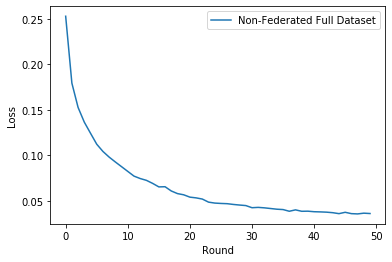

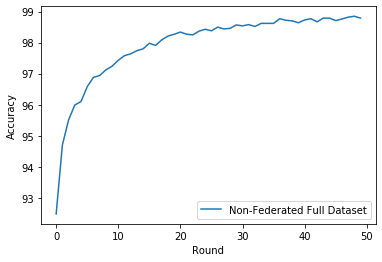

In [14]:
nonfed_alldata_mgr = FederatedManager('Non-Federated Full Dataset', [train_dl], test_dset, Net, verbose=True)

run_mgr(nonfed_alldata_mgr, default_n_rounds, target_acc=default_target_acc)

plot_mgr(nonfed_alldata_mgr)

# The Federated Approach

## Ten Equal Workers

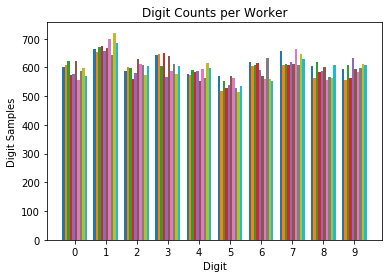

In [15]:
fed_equal_dls = make_fed_dloaders(train_dset)
plot_digit_histogram(fed_equal_dls, 'Digit Counts per Worker')


[[602 666 588 644 577 569 620 657 605 593]
 [608 653 603 646 574 519 606 609 562 558]
 [624 673 597 604 590 553 608 611 620 608]
 [575 676 561 649 585 528 614 610 583 562]
 [576 658 580 566 589 538 590 618 588 633]
 [623 668 630 641 554 570 570 612 600 593]
 [557 699 613 586 593 564 561 663 555 584]
 [589 643 608 612 565 530 634 610 566 598]
 [599 721 573 577 617 514 561 646 563 612]
 [570 685 605 606 598 536 554 629 609 608]]


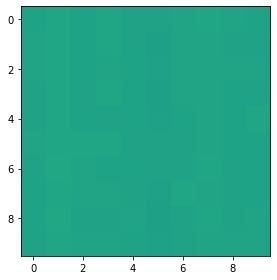

In [16]:
fed_equal_counts = count_dsets([dl.dataset for dl in fed_equal_dls], show_array=True, show_heatmap=True)

In [17]:
fed_equal_mgr = FederatedManager('Federated Unbiased', fed_equal_dls, test_dset, Net, verbose=True)

run_mgr(fed_equal_mgr, default_n_rounds, default_target_acc)

Federated Unbiased manager training with 10 worker(s) for 50 rounds.


Round 0
	wrkr 0		loss: 0.4249 (+0.0000)	acc: 87.71% ( +0.00%)	model:37168
	wrkr 1		loss: 0.4844 (+0.0000)	acc: 85.09% ( +0.00%)	model:56368
	wrkr 2		loss: 0.4770 (+0.0000)	acc: 83.66% ( +0.00%)	model:00496
	wrkr 3		loss: 0.4321 (+0.0000)	acc: 88.22% ( +0.00%)	model:03760
	wrkr 4		loss: 0.4106 (+0.0000)	acc: 88.81% ( +0.00%)	model:02416
	wrkr 5		loss: 0.4300 (+0.0000)	acc: 88.07% ( +0.00%)	model:16336
	wrkr 6		loss: 0.4350 (+0.0000)	acc: 88.49% ( +0.00%)	model:49840
	wrkr 7		loss: 0.6793 (+0.0000)	acc: 76.76% ( +0.00%)	model:15184
	wrkr 8		loss: 0.4554 (+0.0000)	acc: 86.09% ( +0.00%)	model:36848
	wrkr 9		loss: 0.4196 (+0.0000)	acc: 88.59% ( +0.00%)	model:34544
	combined	loss: 0.3994	acc: 89.51%

Round 1
	wrkr 0		loss: 0.3170 (-0.1078)	acc: 90.48% ( +2.77%)	model:19280
	wrkr 1		loss: 0.3359 (-0.1485)	acc: 90.42% ( +5.33%)	model:02224
	wrkr 2		loss: 0.3594 (-0.1176)	acc: 87.90% ( +4.24%)	model:56368
	wrkr 3		loss: 0.3286 (-0.1035)	acc: 90.36% ( +2.14%)	model:05168
	wrkr 4		loss: 0.3162 (-

	wrkr 7		loss: 0.1246 (-0.0098)	acc: 96.27% ( +0.10%)	model:03792
	wrkr 8		loss: 0.1255 (-0.0059)	acc: 96.10% ( -0.07%)	model:16464
	wrkr 9		loss: 0.1332 (-0.0073)	acc: 95.88% ( +0.28%)	model:37168
	combined	loss: 0.1168	acc: 96.57%

Round 12
	wrkr 0		loss: 0.1216 (-0.0127)	acc: 96.21% ( +0.24%)	model:03696
	wrkr 1		loss: 0.1223 (-0.0078)	acc: 96.27% ( +0.04%)	model:51088
	wrkr 2		loss: 0.1257 (+0.0018)	acc: 96.29% ( -0.05%)	model:04816
	wrkr 3		loss: 0.1209 (-0.0137)	acc: 96.21% ( +0.26%)	model:62800
	wrkr 4		loss: 0.1222 (-0.0038)	acc: 96.03% ( -0.16%)	model:29744
	wrkr 5		loss: 0.1158 (-0.0151)	acc: 96.59% ( +0.58%)	model:15696
	wrkr 6		loss: 0.1180 (-0.0223)	acc: 96.51% ( +0.79%)	model:27760
	wrkr 7		loss: 0.1444 (+0.0198)	acc: 95.50% ( -0.77%)	model:34608
	wrkr 8		loss: 0.1210 (-0.0045)	acc: 96.30% ( +0.20%)	model:03792
	wrkr 9		loss: 0.1203 (-0.0129)	acc: 96.43% ( +0.55%)	model:16464
	combined	loss: 0.1094	acc: 96.76%

Round 13
	wrkr 0		loss: 0.1131 (-0.0085)	acc: 96.67% ( +0.46%

	wrkr 3		loss: 0.0747 (-0.0009)	acc: 97.67% ( +0.15%)	model:04144
	wrkr 4		loss: 0.0730 (-0.0046)	acc: 97.80% ( +0.06%)	model:68880
	wrkr 5		loss: 0.0736 (+0.0001)	acc: 97.78% ( +0.01%)	model:05840
	wrkr 6		loss: 0.0711 (-0.0036)	acc: 97.70% ( -0.16%)	model:03632
	wrkr 7		loss: 0.0743 (-0.0045)	acc: 97.64% ( +0.14%)	model:06608
	wrkr 8		loss: 0.0753 (-0.0028)	acc: 97.61% ( -0.02%)	model:38192
	wrkr 9		loss: 0.0744 (-0.0038)	acc: 97.74% ( +0.08%)	model:68688
	combined	loss: 0.0671	acc: 97.97%

Round 24
	wrkr 0		loss: 0.0712 (-0.0023)	acc: 97.73% ( -0.10%)	model:00432
	wrkr 1		loss: 0.0717 (-0.0002)	acc: 97.81% ( +0.05%)	model:68112
	wrkr 2		loss: 0.0732 (-0.0029)	acc: 97.73% ( +0.08%)	model:19280
	wrkr 3		loss: 0.0735 (-0.0012)	acc: 97.76% ( +0.09%)	model:04592
	wrkr 4		loss: 0.0699 (-0.0031)	acc: 97.90% ( +0.10%)	model:04144
	wrkr 5		loss: 0.0692 (-0.0044)	acc: 97.87% ( +0.09%)	model:68880
	wrkr 6		loss: 0.0690 (-0.0021)	acc: 97.85% ( +0.15%)	model:05840
	wrkr 7		loss: 0.0709 (-0.0034)

	wrkr 0		loss: 0.0535 (+0.0003)	acc: 98.32% ( +0.15%)	model:03824
	wrkr 1		loss: 0.0543 (-0.0070)	acc: 98.39% ( +0.33%)	model:13840
	wrkr 2		loss: 0.0548 (-0.0067)	acc: 98.10% ( +0.19%)	model:06608
	wrkr 3		loss: 0.0515 (-0.0018)	acc: 98.33% ( +0.00%)	model:15184
	wrkr 4		loss: 0.0522 (-0.0028)	acc: 98.32% ( +0.09%)	model:36464
	wrkr 5		loss: 0.0530 (-0.0023)	acc: 98.34% ( +0.12%)	model:31440
	wrkr 6		loss: 0.0515 (+0.0000)	acc: 98.33% ( +0.00%)	model:04816
	wrkr 7		loss: 0.0541 (+0.0017)	acc: 98.21% ( -0.10%)	model:68688
	wrkr 8		loss: 0.0559 (+0.0010)	acc: 98.22% ( -0.04%)	model:61712
	wrkr 9		loss: 0.0535 (-0.0011)	acc: 98.21% ( -0.05%)	model:27952
	combined	loss: 0.0482	acc: 98.41%

Round 36
	wrkr 0		loss: 0.0522 (-0.0014)	acc: 98.31% ( -0.01%)	model:68880
	wrkr 1		loss: 0.0540 (-0.0003)	acc: 98.24% ( -0.15%)	model:37680
	wrkr 2		loss: 0.0538 (-0.0011)	acc: 98.25% ( +0.15%)	model:13840
	wrkr 3		loss: 0.0522 (+0.0007)	acc: 98.26% ( -0.07%)	model:06608
	wrkr 4		loss: 0.0509 (-0.0013)

	wrkr 7		loss: 0.0508 (+0.0080)	acc: 98.21% ( -0.32%)	model:48816
	wrkr 8		loss: 0.0450 (-0.0018)	acc: 98.56% ( +0.14%)	model:51088
	wrkr 9		loss: 0.0458 (-0.0012)	acc: 98.49% ( -0.07%)	model:38064
	combined	loss: 0.0407	acc: 98.62%

Round 47
	wrkr 0		loss: 0.0481 (+0.0032)	acc: 98.46% ( -0.02%)	model:29744
	wrkr 1		loss: 0.0446 (+0.0002)	acc: 98.58% ( +0.09%)	model:49840
	wrkr 2		loss: 0.0418 (-0.0040)	acc: 98.65% ( +0.18%)	model:47664
	wrkr 3		loss: 0.0432 (+0.0013)	acc: 98.53% ( -0.09%)	model:26352
	wrkr 4		loss: 0.0426 (-0.0037)	acc: 98.61% ( +0.13%)	model:31440
	wrkr 5		loss: 0.0473 (-0.0006)	acc: 98.41% ( +0.01%)	model:49648
	wrkr 6		loss: 0.0446 (+0.0015)	acc: 98.52% ( +0.00%)	model:47824
	wrkr 7		loss: 0.0442 (-0.0066)	acc: 98.46% ( +0.25%)	model:37168
	wrkr 8		loss: 0.0451 (+0.0000)	acc: 98.56% ( +0.00%)	model:48816
	wrkr 9		loss: 0.0430 (-0.0028)	acc: 98.60% ( +0.11%)	model:51088
	combined	loss: 0.0402	acc: 98.63%

Round 48
	wrkr 0		loss: 0.0446 (-0.0035)	acc: 98.47% ( +0.01%

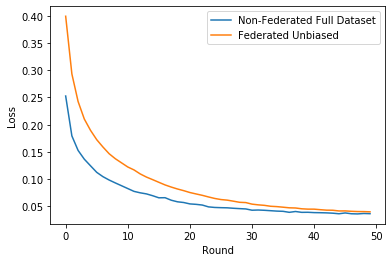

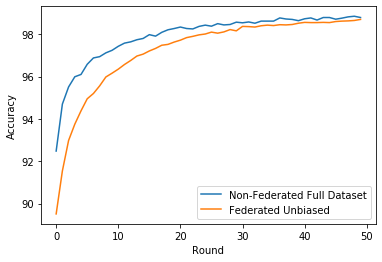

In [18]:
plot_mgr([nonfed_alldata_mgr, fed_equal_mgr])

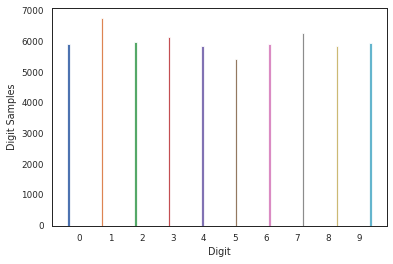

In [95]:
foo_dls = make_fed_dloaders(train_dset, p=1.0)
plot_digit_histogram(foo_dls)

In [96]:
foo_mgr = FederatedManager('Full biased', foo_dls, test_dset, Net, verbose=True)

run_mgr(foo_mgr, default_n_rounds, default_target_acc)

Full biased manager training with 10 worker(s) for 50 rounds.


Round 0
	wrkr 0		loss: 5.1430 (+0.0000)	acc:  9.80% ( +0.00%)	model:04880
	wrkr 1		loss: 5.2621 (+0.0000)	acc: 11.35% ( +0.00%)	model:50128
	wrkr 2		loss: 6.6216 (+0.0000)	acc: 10.32% ( +0.00%)	model:07504
	wrkr 3		loss: 6.3678 (+0.0000)	acc: 10.10% ( +0.00%)	model:50864
	wrkr 4		loss: 6.5068 (+0.0000)	acc:  9.82% ( +0.00%)	model:49648
	wrkr 5		loss: 7.6762 (+0.0000)	acc:  8.92% ( +0.00%)	model:43472
	wrkr 6		loss: 6.2159 (+0.0000)	acc:  9.58% ( +0.00%)	model:41296
	wrkr 7		loss: 6.3683 (+0.0000)	acc: 10.28% ( +0.00%)	model:43920
	wrkr 8		loss: 6.5078 (+0.0000)	acc:  9.74% ( +0.00%)	model:39280
	wrkr 9		loss: 6.6044 (+0.0000)	acc: 10.09% ( +0.00%)	model:37680
	combined	loss: 2.2243	acc: 30.38%

Round 1
	wrkr 0		loss: 5.9936 (+0.8507)	acc:  9.80% ( +0.00%)	model:70800
	wrkr 1		loss: 6.5010 (+1.2389)	acc: 11.35% ( +0.00%)	model:04880
	wrkr 2		loss: 7.2715 (+0.6499)	acc: 10.32% ( +0.00%)	model:50128
	wrkr 3		loss: 6.9556 (+0.5877)	acc: 10.10% ( +0.00%)	model:48944
	wrkr 4		loss: 7.2182 (+

	wrkr 7		loss: 9.1785 (+0.0504)	acc: 10.28% ( +0.00%)	model:71792
	wrkr 8		loss: 9.7005 (+0.3273)	acc:  9.74% ( +0.00%)	model:68784
	wrkr 9		loss: 9.1475 (+0.1455)	acc: 10.09% ( +0.00%)	model:85936
	combined	loss: 1.6760	acc: 69.06%

Round 12
	wrkr 0		loss: 7.9001 (-0.3270)	acc:  9.80% ( +0.00%)	model:07152
	wrkr 1		loss: 8.3143 (-0.1189)	acc: 11.35% ( +0.00%)	model:51184
	wrkr 2		loss: 9.3512 (+0.1905)	acc: 10.32% ( +0.00%)	model:49264
	wrkr 3		loss: 9.3368 (+0.2050)	acc: 10.10% ( +0.00%)	model:06928
	wrkr 4		loss: 9.3547 (+0.1394)	acc:  9.82% ( +0.00%)	model:83760
	wrkr 5		loss: 10.1815 (-0.0855)	acc:  8.92% ( +0.00%)	model:42448
	wrkr 6		loss: 9.5113 (+0.2677)	acc:  9.58% ( +0.00%)	model:49648
	wrkr 7		loss: 9.2822 (+0.1037)	acc: 10.28% ( +0.00%)	model:49840
	wrkr 8		loss: 10.1281 (+0.4276)	acc:  9.74% ( +0.00%)	model:71792
	wrkr 9		loss: 9.4509 (+0.3034)	acc: 10.09% ( +0.00%)	model:68784
	combined	loss: 1.6428	acc: 70.54%

Round 13
	wrkr 0		loss: 8.1670 (+0.2668)	acc:  9.80% ( +0.0

	wrkr 3		loss: 10.6370 (+0.4780)	acc: 10.10% ( +0.00%)	model:73168
	wrkr 4		loss: 10.3319 (+0.3003)	acc:  9.82% ( +0.00%)	model:49040
	wrkr 5		loss: 11.3957 (-0.1271)	acc:  8.92% ( +0.00%)	model:50128
	wrkr 6		loss: 9.5661 (-0.6568)	acc:  9.58% ( +0.00%)	model:69296
	wrkr 7		loss: 9.0616 (-0.1458)	acc: 10.28% ( +0.00%)	model:50576
	wrkr 8		loss: 12.2326 (+0.6433)	acc:  9.74% ( +0.00%)	model:82928
	wrkr 9		loss: 10.5081 (-0.3771)	acc: 10.09% ( +0.00%)	model:68464
	combined	loss: 1.3342	acc: 75.89%

Round 24
	wrkr 0		loss: 7.1027 (-0.6759)	acc:  9.80% ( +0.00%)	model:08240
	wrkr 1		loss: 7.1037 (-0.1338)	acc: 11.35% ( +0.00%)	model:39536
	wrkr 2		loss: 10.2853 (+0.3994)	acc: 10.32% ( +0.00%)	model:08816
	wrkr 3		loss: 10.3016 (-0.3353)	acc: 10.10% ( +0.00%)	model:43152
	wrkr 4		loss: 10.2805 (-0.0514)	acc:  9.82% ( +0.00%)	model:06832
	wrkr 5		loss: 11.2298 (-0.1658)	acc:  8.92% ( +0.00%)	model:49040
	wrkr 6		loss: 9.9159 (+0.3498)	acc:  9.58% ( +0.00%)	model:50128
	wrkr 7		loss: 9.3365 

	wrkr 9		loss: 10.8468 (-1.2996)	acc: 10.09% ( +0.00%)	model:41680
	combined	loss: 1.1027	acc: 79.23%

Round 35
	wrkr 0		loss: 5.9482 (-0.6210)	acc:  9.80% ( +0.00%)	model:71248
	wrkr 1		loss: 6.0668 (+0.2152)	acc: 12.62% ( -0.13%)	model:04944
	wrkr 2		loss: 10.3842 (+0.1328)	acc: 10.32% ( +0.00%)	model:70640
	wrkr 3		loss: 10.4176 (+0.1520)	acc: 10.10% ( +0.00%)	model:06160
	wrkr 4		loss: 10.2928 (-0.3816)	acc:  9.82% ( +0.00%)	model:05648
	wrkr 5		loss: 11.8584 (-1.0293)	acc:  8.92% ( +0.00%)	model:49040
	wrkr 6		loss: 9.1772 (+0.2531)	acc:  9.58% ( +0.00%)	model:06672
	wrkr 7		loss: 8.3684 (-0.6702)	acc: 10.28% ( +0.00%)	model:71760
	wrkr 8		loss: 12.8468 (-0.1891)	acc:  9.74% ( +0.00%)	model:69296
	wrkr 9		loss: 11.3746 (+0.5278)	acc: 10.09% ( +0.00%)	model:37360
	combined	loss: 1.0828	acc: 79.54%

Round 36
	wrkr 0		loss: 6.1898 (+0.2416)	acc:  9.80% ( +0.00%)	model:08816
	wrkr 1		loss: 5.6676 (-0.3993)	acc: 13.29% ( +0.67%)	model:52144
	wrkr 2		loss: 9.4390 (-0.9452)	acc: 10.32% (

	wrkr 5		loss: 12.1156 (-0.8047)	acc:  8.92% ( +0.00%)	model:37936
	wrkr 6		loss: 8.4432 (+0.2828)	acc:  9.58% ( +0.00%)	model:09520
	wrkr 7		loss: 7.7206 (-0.3204)	acc: 10.28% ( +0.00%)	model:07056
	wrkr 8		loss: 14.4587 (+2.0273)	acc:  9.74% ( +0.00%)	model:39984
	wrkr 9		loss: 11.9784 (+0.3474)	acc: 10.09% ( +0.00%)	model:43216
	combined	loss: 0.9217	acc: 81.60%

Round 47
	wrkr 0		loss: 5.0388 (-0.9750)	acc: 11.96% ( +2.10%)	model:48656
	wrkr 1		loss: 4.6713 (-0.1718)	acc: 17.03% ( +0.52%)	model:48944
	wrkr 2		loss: 10.0110 (+0.0776)	acc: 10.32% ( +0.00%)	model:07760
	wrkr 3		loss: 10.9338 (+0.8000)	acc: 10.10% ( +0.00%)	model:39792
	wrkr 4		loss: 9.9028 (-0.7044)	acc:  9.82% ( +0.00%)	model:39536
	wrkr 5		loss: 13.2111 (+1.0955)	acc:  8.92% ( +0.00%)	model:39152
	wrkr 6		loss: 8.6765 (+0.2333)	acc:  9.58% ( +0.00%)	model:37936
	wrkr 7		loss: 8.2362 (+0.5157)	acc: 10.28% ( +0.00%)	model:09520
	wrkr 8		loss: 12.8577 (-1.6010)	acc:  9.74% ( +0.00%)	model:07056
	wrkr 9		loss: 11.5161 (

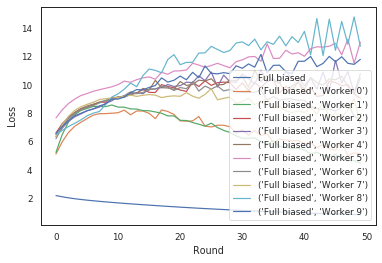

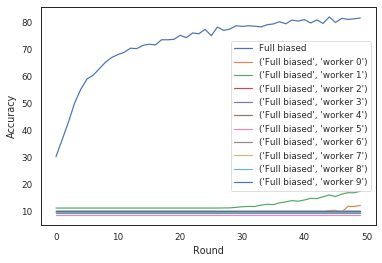

In [116]:
plot_mgr([
#            nonfed_alldata_mgr, 
#            fed_equal_mgr, 
            foo_mgr
         ], 
            plot_workers=True,
        )

# Federation with Varying Example Distributions Per Worker


## Spliting the Decks into Uneven Piles

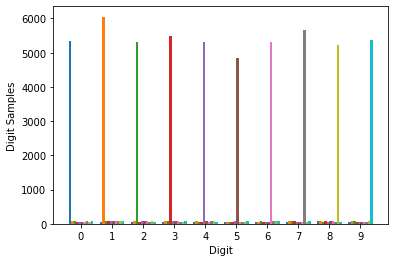

In [19]:
fed_weighted_dls = make_fed_dloaders(train_dset, p=0.9)
plot_digit_histogram(fed_weighted_dls)

In [20]:
check_dsets([dl.dataset for dl in fed_weighted_dls])

Counter({0: 5330, 8: 78, 3: 66, 5: 66, 7: 64, 6: 64, 9: 60, 4: 58, 2: 56, 1: 53})
Counter({1: 6051, 0: 81, 2: 80, 7: 71, 3: 69, 9: 68, 4: 68, 8: 68, 5: 67, 6: 64})
Counter({2: 5325, 1: 80, 3: 77, 6: 72, 7: 71, 9: 71, 0: 68, 8: 65, 4: 54, 5: 52})
Counter({3: 5497, 1: 94, 7: 75, 8: 73, 9: 63, 4: 62, 0: 58, 6: 58, 5: 55, 2: 53})
Counter({4: 5298, 5: 79, 2: 75, 3: 73, 1: 72, 8: 67, 9: 60, 6: 54, 0: 54, 7: 53})
Counter({5: 4852, 1: 81, 2: 79, 8: 78, 3: 78, 4: 72, 0: 67, 7: 60, 6: 58, 9: 57})
Counter({6: 5321, 8: 77, 2: 76, 1: 76, 3: 73, 9: 65, 7: 64, 0: 62, 5: 59, 4: 47})
Counter({7: 5673, 1: 79, 4: 73, 0: 71, 6: 68, 2: 67, 8: 64, 9: 64, 3: 63, 5: 61})
Counter({8: 5226, 6: 82, 2: 80, 1: 78, 9: 77, 4: 68, 3: 65, 7: 62, 5: 60, 0: 56})
Counter({9: 5364, 1: 78, 6: 77, 0: 76, 7: 72, 5: 70, 3: 70, 2: 67, 8: 55, 4: 42})


array([[602, 666, 588, 644, 577, 569, 620, 657, 605, 593],
       [608, 653, 603, 646, 574, 519, 606, 609, 562, 558],
       [624, 673, 597, 604, 590, 553, 608, 611, 620, 608],
       [575, 676, 561, 649, 585, 528, 614, 610, 583, 562],
       [576, 658, 580, 566, 589, 538, 590, 618, 588, 633],
       [623, 668, 630, 641, 554, 570, 570, 612, 600, 593],
       [557, 699, 613, 586, 593, 564, 561, 663, 555, 584],
       [589, 643, 608, 612, 565, 530, 634, 610, 566, 598],
       [599, 721, 573, 577, 617, 514, 561, 646, 563, 612],
       [570, 685, 605, 606, 598, 536, 554, 629, 609, 608]])

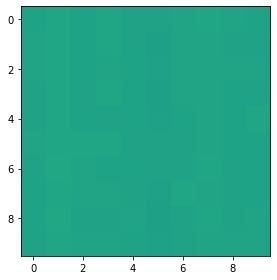

In [21]:
count_dsets([dl.dataset for dl in fed_equal_dls], show_array=False, show_heatmap=True)

array([[5330,   53,   56,   66,   58,   66,   64,   64,   78,   60],
       [  81, 6051,   80,   69,   68,   67,   64,   71,   68,   68],
       [  68,   80, 5325,   77,   54,   52,   72,   71,   65,   71],
       [  58,   94,   53, 5497,   62,   55,   58,   75,   73,   63],
       [  54,   72,   75,   73, 5298,   79,   54,   53,   67,   60],
       [  67,   81,   79,   78,   72, 4852,   58,   60,   78,   57],
       [  62,   76,   76,   73,   47,   59, 5321,   64,   77,   65],
       [  71,   79,   67,   63,   73,   61,   68, 5673,   64,   64],
       [  56,   78,   80,   65,   68,   60,   82,   62, 5226,   77],
       [  76,   78,   67,   70,   42,   70,   77,   72,   55, 5364]])

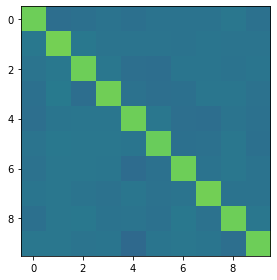

In [22]:
count_dsets([dl.dataset for dl in fed_weighted_dls], show_array=False, show_heatmap=True)

Fed Bias manager training with 10 worker(s) for 50 rounds.


Round 0
	wrkr 0		loss: 2.0643 (+0.0000)	acc: 37.35% ( +0.00%)	model:53168
	wrkr 1		loss: 1.8473 (+0.0000)	acc: 49.39% ( +0.00%)	model:38704
	wrkr 2		loss: 2.4374 (+0.0000)	acc: 13.48% ( +0.00%)	model:06768
	wrkr 3		loss: 2.7151 (+0.0000)	acc: 11.06% ( +0.00%)	model:65296
	wrkr 4		loss: 2.3235 (+0.0000)	acc: 31.47% ( +0.00%)	model:04400
	wrkr 5		loss: 2.6048 (+0.0000)	acc:  8.92% ( +0.00%)	model:62096
	wrkr 6		loss: 2.0920 (+0.0000)	acc: 28.87% ( +0.00%)	model:14416
	wrkr 7		loss: 1.9303 (+0.0000)	acc: 34.03% ( +0.00%)	model:59856
	wrkr 8		loss: 2.8047 (+0.0000)	acc:  9.93% ( +0.00%)	model:70128
	wrkr 9		loss: 2.7058 (+0.0000)	acc: 15.88% ( +0.00%)	model:68144
	combined	loss: 1.7345	acc: 73.72%

Round 1
	wrkr 0		loss: 1.3158 (-0.7485)	acc: 62.23% (+24.88%)	model:02640
	wrkr 1		loss: 1.0677 (-0.7796)	acc: 69.09% (+19.70%)	model:38064
	wrkr 2		loss: 1.7015 (-0.7360)	acc: 40.94% (+27.46%)	model:38704
	wrkr 3		loss: 1.5154 (-1.1997)	acc: 50.94% (+39.88%)	model:06768
	wrkr 4		loss: 1.0294 (-

	wrkr 7		loss: 0.4257 (+0.0106)	acc: 86.02% ( -1.00%)	model:70768
	wrkr 8		loss: 0.5500 (+0.0432)	acc: 81.53% ( -1.45%)	model:97488
	wrkr 9		loss: 0.5391 (-0.0082)	acc: 81.57% ( +0.23%)	model:62960
	combined	loss: 0.2409	acc: 92.89%

Round 12
	wrkr 0		loss: 0.3948 (+0.0648)	acc: 88.06% ( -2.04%)	model:01232
	wrkr 1		loss: 0.3667 (-0.0319)	acc: 88.86% ( +1.32%)	model:42320
	wrkr 2		loss: 0.4218 (-0.0583)	acc: 86.75% ( +2.93%)	model:35920
	wrkr 3		loss: 0.7483 (+0.1406)	acc: 74.77% ( -5.70%)	model:59472
	wrkr 4		loss: 0.5621 (+0.0435)	acc: 81.79% ( -1.07%)	model:55632
	wrkr 5		loss: 0.4003 (-0.1415)	acc: 87.31% ( +5.28%)	model:61072
	wrkr 6		loss: 0.4199 (+0.0427)	acc: 87.48% ( -1.17%)	model:82640
	wrkr 7		loss: 0.3925 (-0.0332)	acc: 87.24% ( +1.22%)	model:69232
	wrkr 8		loss: 0.4552 (-0.0948)	acc: 84.55% ( +3.02%)	model:70768
	wrkr 9		loss: 0.7749 (+0.2357)	acc: 74.18% ( -7.39%)	model:97488
	combined	loss: 0.2366	acc: 92.94%

Round 13
	wrkr 0		loss: 0.3385 (-0.0563)	acc: 90.02% ( +1.96%

	wrkr 3		loss: 0.5260 (+0.1423)	acc: 82.21% ( -5.10%)	model:62000
	wrkr 4		loss: 0.3466 (-0.1228)	acc: 88.45% ( +3.56%)	model:38704
	wrkr 5		loss: 0.3892 (+0.0461)	acc: 87.56% ( -1.33%)	model:42192
	wrkr 6		loss: 0.2510 (-0.0310)	acc: 92.35% ( +0.84%)	model:36784
	wrkr 7		loss: 0.2893 (+0.0261)	acc: 90.89% ( -0.86%)	model:13072
	wrkr 8		loss: 0.4146 (-0.0856)	acc: 86.56% ( +2.59%)	model:16336
	wrkr 9		loss: 0.3590 (-0.0542)	acc: 87.89% ( +1.85%)	model:70960
	combined	loss: 0.1699	acc: 94.86%

Round 24
	wrkr 0		loss: 0.2461 (+0.0230)	acc: 92.65% ( -0.79%)	model:60048
	wrkr 1		loss: 0.2412 (-0.0220)	acc: 92.60% ( +1.18%)	model:14416
	wrkr 2		loss: 0.3963 (+0.0999)	acc: 86.89% ( -4.19%)	model:68528
	wrkr 3		loss: 0.3578 (-0.1681)	acc: 87.82% ( +5.61%)	model:37168
	wrkr 4		loss: 0.3801 (+0.0335)	acc: 87.63% ( -0.82%)	model:62000
	wrkr 5		loss: 0.2992 (-0.0900)	acc: 90.22% ( +2.66%)	model:38704
	wrkr 6		loss: 0.2786 (+0.0276)	acc: 91.66% ( -0.69%)	model:05040
	wrkr 7		loss: 0.2580 (-0.0313)

	wrkr 0		loss: 0.2343 (-0.0346)	acc: 93.10% ( +0.96%)	model:03920
	wrkr 1		loss: 0.2352 (+0.0052)	acc: 92.55% ( -0.15%)	model:35152
	wrkr 2		loss: 0.2452 (+0.0012)	acc: 92.35% ( -0.04%)	model:01776
	wrkr 3		loss: 0.3744 (+0.0470)	acc: 86.91% ( -1.60%)	model:43408
	wrkr 4		loss: 0.2458 (+0.0092)	acc: 92.10% ( -0.35%)	model:01968
	wrkr 5		loss: 0.2722 (-0.0227)	acc: 91.24% ( +0.68%)	model:16336
	wrkr 6		loss: 0.2399 (+0.0092)	acc: 92.80% ( -0.04%)	model:16336
	wrkr 7		loss: 0.2611 (-0.1125)	acc: 91.91% ( +4.20%)	model:75280
	wrkr 8		loss: 0.3574 (-0.0023)	acc: 88.13% ( +0.02%)	model:73616
	wrkr 9		loss: 0.4685 (+0.0601)	acc: 84.19% ( -1.50%)	model:54928
	combined	loss: 0.1320	acc: 95.90%

Round 36
	wrkr 0		loss: 0.1932 (-0.0410)	acc: 94.35% ( +1.25%)	model:01712
	wrkr 1		loss: 0.2090 (-0.0263)	acc: 93.38% ( +0.83%)	model:03920
	wrkr 2		loss: 0.2001 (-0.0451)	acc: 93.93% ( +1.58%)	model:70064
	wrkr 3		loss: 0.5575 (+0.1831)	acc: 81.62% ( -5.29%)	model:97552
	wrkr 4		loss: 0.3488 (+0.1030)

	wrkr 7		loss: 0.2759 (+0.0668)	acc: 91.34% ( -2.38%)	model:53552
	wrkr 8		loss: 0.2859 (-0.0746)	acc: 90.62% ( +2.70%)	model:73616
	wrkr 9		loss: 0.3104 (+0.0358)	acc: 89.58% ( -0.69%)	model:06768
	combined	loss: 0.1106	acc: 96.71%

Round 47
	wrkr 0		loss: 0.2250 (+0.0652)	acc: 93.20% ( -2.06%)	model:03952
	wrkr 1		loss: 0.1715 (+0.0070)	acc: 94.33% ( -0.54%)	model:01104
	wrkr 2		loss: 0.1964 (-0.0116)	acc: 93.95% ( +0.23%)	model:65296
	wrkr 3		loss: 0.2185 (-0.0603)	acc: 93.11% ( +2.31%)	model:04624
	wrkr 4		loss: 0.2202 (-0.0321)	acc: 92.88% ( +1.17%)	model:55600
	wrkr 5		loss: 0.2589 (+0.0402)	acc: 91.76% ( -1.44%)	model:38064
	wrkr 6		loss: 0.1993 (-0.0087)	acc: 93.91% ( +0.16%)	model:75664
	wrkr 7		loss: 0.2632 (-0.0127)	acc: 91.69% ( +0.35%)	model:37008
	wrkr 8		loss: 0.2602 (-0.0257)	acc: 91.52% ( +0.90%)	model:53552
	wrkr 9		loss: 0.4056 (+0.0953)	acc: 86.19% ( -3.39%)	model:73616
	combined	loss: 0.1084	acc: 96.67%

Round 48
	wrkr 0		loss: 0.1679 (-0.0570)	acc: 95.00% ( +1.80%

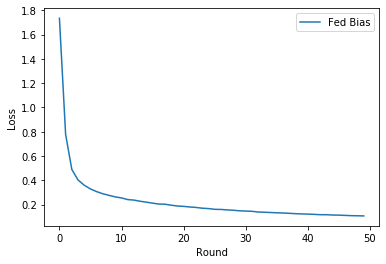

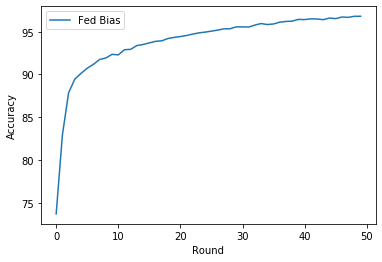

In [23]:
fed_weighted_mgr = FederatedManager('Fed Bias', fed_weighted_dls, test_dset, Net, verbose=True)
run_mgr(fed_weighted_mgr, default_n_rounds, default_target_acc)
plot_mgr(fed_weighted_mgr)

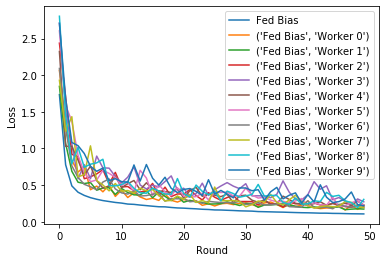

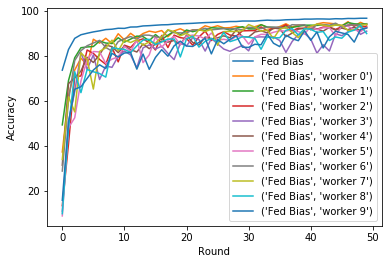

In [24]:
plot_mgr(fed_weighted_mgr, plot_workers=True)

# Difficult Decisions

These matrices should show us which number pairs our model has trouble discriminating. (Spoiler alert: its 4-9 and 3-5 pairs. The 5-8-9 triplet looks troublesome, too.)

In [77]:
nonfed_alldata_mgr.round()
show_model_confusion(nonfed_alldata_mgr)
show_some_predictions(nonfed_alldata_mgr)

TypeError: show_model_confusion() missing 2 required positional arguments: 'examples' and 'targets'

In [ ]:
nonfed_alldata_mgr.round()
show_model_confusion(nonfed_alldata_mgr)
show_some_predictions(nonfed_alldata_mgr)

In [ ]:
nonfed_alldata_mgr.round()
show_model_confusion(nonfed_alldata_mgr)
show_some_predictions(nonfed_alldata_mgr)

In [ ]:
nonfed_alldata_mgr.round()
show_model_confusion(nonfed_alldata_mgr)
show_some_predictions(nonfed_alldata_mgr)

Let's see whether we can identify which digits give us the most trouble. Looks like 5, 8, and 9 are the most difficult.

In [84]:
eval_set = get_eval_set(model=nonfed_alldata_mgr.model, examples=nonfed_alldata_mgr.Xtest, targets=nonfed_alldata_mgr.ytest)
misses = [ev for ev in eval_set if (ev['y'] != ev['pred'])]
cm = confusion_matrix(misses, norm=False, mirror=True)

print(cm)
print(sorted([(cm[i].sum(), i, cm[i].argmax()) for i in range(len(cm))]))

[[ 0.  0. 13.  5.  1. 14. 20.  5.  8. 12.]
 [ 0.  0. 10.  3.  4.  5.  6. 11. 22.  7.]
 [13. 10.  0. 35. 20.  6. 16. 38. 33.  6.]
 [ 5.  3. 35.  0.  3. 58.  2. 20. 44. 16.]
 [ 1.  4. 20.  3.  0.  8. 24. 10. 17. 72.]
 [14.  5.  6. 58.  8.  0. 26.  8. 42. 12.]
 [20.  6. 16.  2. 24. 26.  0.  1. 13.  1.]
 [ 5. 11. 38. 20. 10.  8.  1.  0. 13. 42.]
 [ 8. 22. 33. 44. 17. 42. 13. 13.  0. 13.]
 [12.  7.  6. 16. 72. 12.  1. 42. 13.  0.]]
[(68.0, 1, 8), (78.0, 0, 6), (109.0, 6, 5), (148.0, 7, 9), (159.0, 4, 9), (177.0, 2, 7), (179.0, 5, 3), (181.0, 9, 4), (186.0, 3, 5), (205.0, 8, 3)]


In [ ]:
#TODO - Show the highest confidence picks

# Stacking the Deck Differently

make_fed_dloaders()

def make_custom_dsets(dset, n_workers=10, biases=[0.0]):
    
    dsets=[]
    
    
    
    return dls

In [67]:
def show_some_predictions(manager, n_predictions=3):
    
    for i in range(n_predictions):
        example = manager.workers[0].dataloader.dataset[i][0]
        target = manager.workers[0].dataloader.dataset[i][1]
        model = manager.model.cpu()

        #example = example.to('cuda')
        #model = model.to('cuda')

        prediction = model(example)

        #prediction = prediction.to('cpu')

        #print(prediction)
        #show_prediction(example, prediction, target)

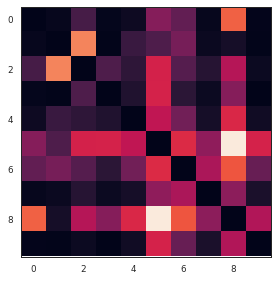

In [68]:
nonfed_alldata_mgr = FederatedManager('Non-Federated Full Dataset',fed_equal_dls, test_dset, Net)
show_model_confusion(nonfed_alldata_mgr.model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)
show_some_predictions(nonfed_alldata_mgr)
#show_prediction(nonfed_alldata_mgr.Xtest, output nonfed_alldata_mgr.ytest)

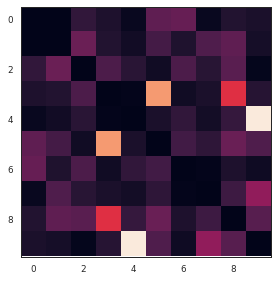

In [69]:
nonfed_alldata_mgr.round()
#show_model_confusion(nonfed_alldata_mgr.model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)

for worker in tqdm(nonfed_alldata_mgr.workers):
    show_model_confusion(worker.model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)

#show_model_confusion(nonfed_alldata_mgr.workers[0].model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)
#show_some_predictions(nonfed_alldata_mgr)

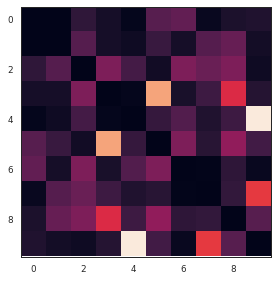

In [70]:
nonfed_alldata_mgr.round()
#show_model_confusion(nonfed_alldata_mgr.model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)

for worker in tqdm(nonfed_alldata_mgr.workers):
    show_model_confusion(worker.model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)

#show_model_confusion(nonfed_alldata_mgr.workers[0].model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)
#show_some_predictions(nonfed_alldata_mgr)

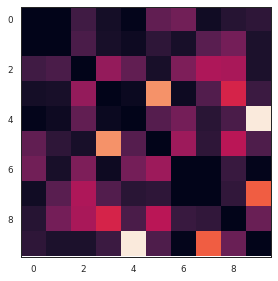

In [71]:
nonfed_alldata_mgr.round()
#show_model_confusion(nonfed_alldata_mgr.model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)

for worker in tqdm(nonfed_alldata_mgr.workers):
    show_model_confusion(worker.model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)

#show_model_confusion(nonfed_alldata_mgr.workers[0].model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)
#show_some_predictions(nonfed_alldata_mgr)

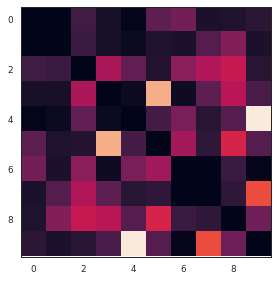

In [72]:
nonfed_alldata_mgr.round()
#show_model_confusion(nonfed_alldata_mgr.model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)

for worker in tqdm(nonfed_alldata_mgr.workers):
    show_model_confusion(worker.model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)

#show_model_confusion(nonfed_alldata_mgr.workers[0].model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)
#show_some_predictions(nonfed_alldata_mgr)

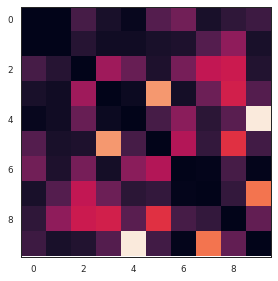

In [73]:
nonfed_alldata_mgr.round()
#show_model_confusion(nonfed_alldata_mgr.model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)

for worker in tqdm(nonfed_alldata_mgr.workers):
    show_model_confusion(worker.model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)

#show_model_confusion(nonfed_alldata_mgr.workers[0].model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)
#show_some_predictions(nonfed_alldata_mgr)

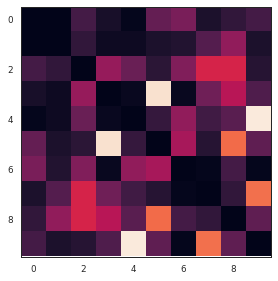

In [74]:
nonfed_alldata_mgr.round()
#show_model_confusion(nonfed_alldata_mgr.model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)

for worker in tqdm(nonfed_alldata_mgr.workers):
    show_model_confusion(worker.model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)

#show_model_confusion(nonfed_alldata_mgr.workers[0].model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)
#show_some_predictions(nonfed_alldata_mgr)

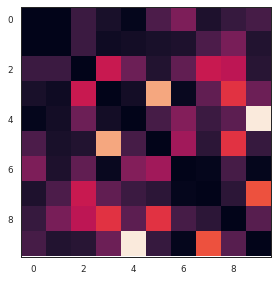

In [75]:
nonfed_alldata_mgr.round()
#show_model_confusion(nonfed_alldata_mgr.model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)

for worker in tqdm(nonfed_alldata_mgr.workers):
    show_model_confusion(worker.model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)

#show_model_confusion(nonfed_alldata_mgr.workers[0].model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)
#show_some_predictions(nonfed_alldata_mgr)

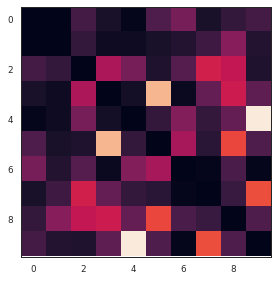

In [76]:
nonfed_alldata_mgr.round()
#show_model_confusion(nonfed_alldata_mgr.model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)

for worker in tqdm(nonfed_alldata_mgr.workers):
    show_model_confusion(worker.model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)

#show_model_confusion(nonfed_alldata_mgr.workers[0].model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)
#show_some_predictions(nonfed_alldata_mgr)

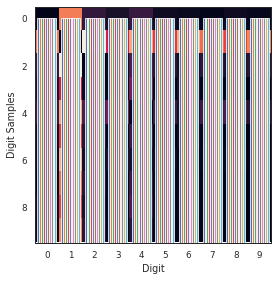

In [92]:
custom_dls = make_fed_dloaders(train_dset, p=0.9)
plot_digit_histogram(custom_dls)
custom_mgr = FederatedManager('Federated Pairs Dataset', custom_dls, test_dset, Net)
show_model_confusion(custom_mgr.model, custom_mgr.Xtest, custom_mgr.ytest)
show_some_predictions(custom_mgr)
#show_prediction(custom_mgr.Xtest, output nonfed_alldata_mgr.ytest)

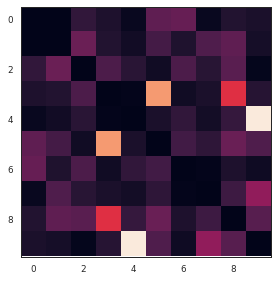

In [69]:
nonfed_alldata_mgr.round()
#show_model_confusion(nonfed_alldata_mgr.model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)

for worker in tqdm(nonfed_alldata_mgr.workers):
    show_model_confusion(worker.model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)

#show_model_confusion(nonfed_alldata_mgr.workers[0].model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)
#show_some_predictions(nonfed_alldata_mgr)

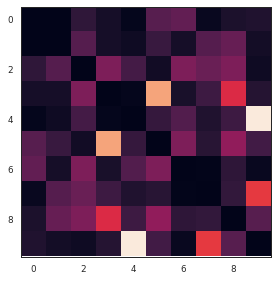

In [70]:
nonfed_alldata_mgr.round()
#show_model_confusion(nonfed_alldata_mgr.model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)

for worker in tqdm(nonfed_alldata_mgr.workers):
    show_model_confusion(worker.model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)

#show_model_confusion(nonfed_alldata_mgr.workers[0].model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)
#show_some_predictions(nonfed_alldata_mgr)

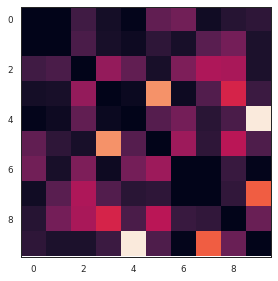

In [71]:
nonfed_alldata_mgr.round()
#show_model_confusion(nonfed_alldata_mgr.model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)

for worker in tqdm(nonfed_alldata_mgr.workers):
    show_model_confusion(worker.model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)

#show_model_confusion(nonfed_alldata_mgr.workers[0].model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)
#show_some_predictions(nonfed_alldata_mgr)

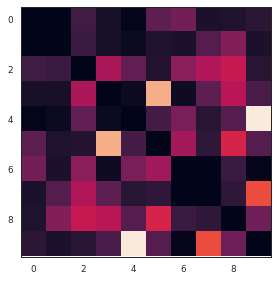

In [72]:
nonfed_alldata_mgr.round()
#show_model_confusion(nonfed_alldata_mgr.model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)

for worker in tqdm(nonfed_alldata_mgr.workers):
    show_model_confusion(worker.model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)

#show_model_confusion(nonfed_alldata_mgr.workers[0].model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)
#show_some_predictions(nonfed_alldata_mgr)

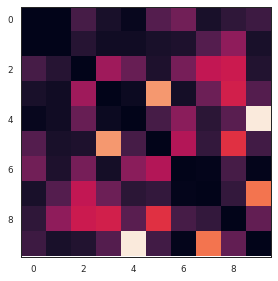

In [73]:
nonfed_alldata_mgr.round()
#show_model_confusion(nonfed_alldata_mgr.model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)

for worker in tqdm(nonfed_alldata_mgr.workers):
    show_model_confusion(worker.model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)

#show_model_confusion(nonfed_alldata_mgr.workers[0].model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)
#show_some_predictions(nonfed_alldata_mgr)

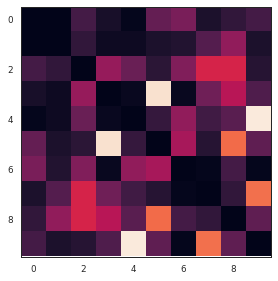

In [74]:
nonfed_alldata_mgr.round()
#show_model_confusion(nonfed_alldata_mgr.model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)

for worker in tqdm(nonfed_alldata_mgr.workers):
    show_model_confusion(worker.model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)

#show_model_confusion(nonfed_alldata_mgr.workers[0].model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)
#show_some_predictions(nonfed_alldata_mgr)

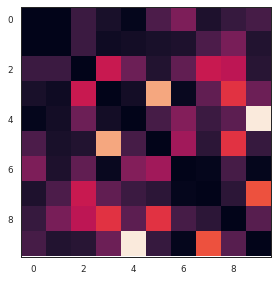

In [75]:
nonfed_alldata_mgr.round()
#show_model_confusion(nonfed_alldata_mgr.model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)

for worker in tqdm(nonfed_alldata_mgr.workers):
    show_model_confusion(worker.model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)

#show_model_confusion(nonfed_alldata_mgr.workers[0].model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)
#show_some_predictions(nonfed_alldata_mgr)

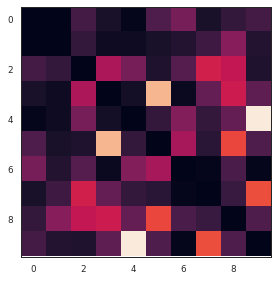

In [76]:
nonfed_alldata_mgr.round()
#show_model_confusion(nonfed_alldata_mgr.model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)

for worker in tqdm(nonfed_alldata_mgr.workers):
    show_model_confusion(worker.model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)

#show_model_confusion(nonfed_alldata_mgr.workers[0].model, nonfed_alldata_mgr.Xtest, nonfed_alldata_mgr.ytest)
#show_some_predictions(nonfed_alldata_mgr)

ps pre transpose
 [[1.e+05 1.e+00]
 [0.e+00 1.e+00]
 [0.e+00 1.e+00]
 [0.e+00 1.e+00]
 [0.e+00 1.e+00]
 [0.e+00 1.e+00]
 [0.e+00 1.e+00]
 [0.e+00 1.e+00]
 [0.e+00 1.e+00]
 [0.e+00 1.e+00]] 

ps post transpose
 [[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]] 

sum per digit (should total 10.0)
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] = 10.0 

sum per worker (should total 10.0)
 [1.0, 9.0] = 10.0 

examples per worker (should total 60,000)
 [5923, 54077] = 60000 

Counter({0: 5923})
Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


array([[5923,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]])

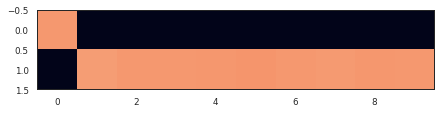

In [110]:
n_workers = 2

_, y = consume_dataset(train_dset)
classes = set(y.numpy())
n_classes = len(classes)

ps = np.array([[1.0] * n_workers] * n_classes)

# Incorporate bias parameters here
p=1e5
ps[0][0] = p
ps[1][0] = 0 
ps[2][0] = 0 
ps[3][0] = 0 
ps[4][0] = 0 
ps[5][0] = 0 
ps[6][0] = 0 
ps[7][0] = 0 
ps[8][0] = 0 
ps[9][0] = 0


#ps[9][0] = 1e3 # relative allocation of '9's to worker 0
#ps[4][0] = 1e3 # relative allocation of '4's to worker 0

#ps[2][2] = 7
#ps[4][7] = 2

print('ps pre transpose\n', np.array_str(ps, precision=3), '\n')

for x in range(10000):
    ps = np.transpose(ps)
    ps = np.array([ps[i]/ps[i].sum() for i in range(len(ps))])
    ps = np.transpose(ps)
    ps = np.array([ps[i]/ps[i].sum() for i in range(len(ps))])

print('ps post transpose\n', np.array_str(ps, precision=3), '\n')
print('sum per digit (should total 10.0)\n', [sum(ps[i]) for i in range(len(ps))], '=', sum([sum(ps[i]) for i in range(len(ps))]) , '\n')
print('sum per worker (should total 10.0)\n', [sum([ps[j][i]for j in range(len(ps))]) for i in range(len(ps[0]))], '=', sum([sum([ps[j][i]for j in range(len(ps))]) for i in range(len(ps[0]))]), '\n')

idx_dset = np.array([np.random.choice(n_workers, p=ps[yi]) for yi in y])
#print('idx_dset', type(idx_dset), len(idx_dset), idx_dset)

dset_idx = [np.where(idx_dset == di)[0] for di in range(n_workers)]

print('examples per worker (should total 60,000)\n', [len(dset_idx[i]) for i in range(len(dset_idx))], '=', sum([len(dset_idx[i]) for i in range(len(dset_idx))]), '\n')

custom_dsets = [Subset(train_dset, di) for di in dset_idx]

check_dsets(custom_dsets)

count_dsets(custom_dsets, show_array=False, show_heatmap=True)

In [87]:
import pprint

def get_datasets(manager):
    
    datasets = [worker.dataloader.dataset for worker in manager.workers]
    
    return datasets

#pp.pprint(get_datasets(fed_weighted_mgr)[7][777])

fed_weighted_tdsts = get_datasets(fed_weighted_mgr)

#tcnt = Counter(get_datasets(fed_weighted_mgr)[0])
#tcnt=Counter([5])
#pp.pprint(tcnt.most_common(5))

In [88]:
pp.pprint(len(custom_dsets[0]))
#pp.pprint(custom_dsets[0][0])
#pp.pprint(custom_dsets[0][0][0])
#pp.pprint(custom_dsets[0][0][1])

#tcnt = Counter(custom_dsets[0])
#print(tcnt)


12664


In [ ]:
custom_dls = [DataLoader(dset, batch_size=256, shuffle=True) for dset in custom_dsets]

In [ ]:
plot_digit_histogram(custom_dls)

In [ ]:
count_dsets([dl.dataset for dl in custom_dls], show_array=True, show_heatmap=True)

In [ ]:
custom_mgr = FederatedManager('Custom Pairs', custom_dls, test_dset, Net, verbose=True)
run_mgr(custom_mgr, 20, None)
plot_mgr(custom_mgr, plot_workers=True)

In [ ]:
plot_mgr([custom_mgr, nonfed_alldata_mgr, fed_equal_mgr])

In [ ]:
#count_dsets(subsets, heatmap=True)

In [44]:
def make_fed_dloaders(dset, p=None, batch_size=64, shuffle=True):
    
    return [DataLoader(dset, batch_size, shuffle) for dset in make_fed_dsets(dset, p=p)]
    
def make_fed_dsets(dset, p=None):
    _, y = consume_dataset(dset)
    classes = set(y.numpy())
    n_classes = len(classes)
    idx_dset = index_to_dataset(y, p=p)
    dset_idx = [np.where(idx_dset == di)[0] for di in range(n_classes)]
    return [Subset(dset, di) for di in dset_idx]

def index_to_dataset(y, p=None):
    classes = set(y.numpy())
    n_classes = len(classes)
    p = p or 1/n_classes
    pnot = (1-p)/(n_classes-1)
    ps = np.full((n_classes, n_classes), pnot)
    np.fill_diagonal(ps, p)
    return np.array([np.random.choice(10, p=ps[yi]) for yi in y])

### Some tinkering to display the outputs of an evaluation

Actual Digit   : 3
Predicted Digit: 0 ( +15.44)
Nearest Digit  : 5 (  +3.96)
Farthest Digit : 1 ( -11.42)


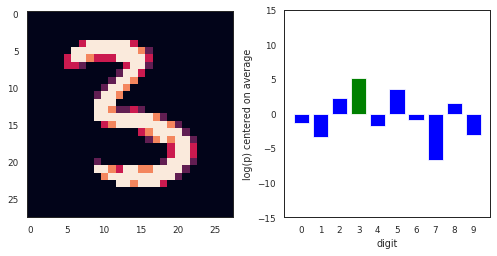

In [89]:
import random

xs, ys = next(iter(test_dl))

idx = random.randint(0, len(xs))
x = xs[idx]
y = ys[idx]

model = nonfed_alldata_mgr.model
#model = Net()
model = model.cpu()

with torch.no_grad():
    log_preds = model(xs)

#pp.pprint(log_preds[0])
#print('log_preds[0].argmax():', log_preds[0].argmax())
#print('log_preds[0][logpreds[0].argmax()]:', log_preds[0][log_preds[0].argmax()])

show_prediction(x, log_preds[idx], y)

#print(log_preds[0].tolist())

pred_vals = sorted(zip(range(10), log_preds[0].tolist()), key=lambda item: item[1], reverse=True)

#pp.pprint(pred_vals)

print('Actual Digit   : {:d}'.format(y.item()))
print('Predicted Digit: {:d} ({:+7.2f})'.format(pred_vals[0][0], pred_vals[0][1]))
print('Nearest Digit  : {:d} ({:+7.2f})'.format(pred_vals[1][0], pred_vals[1][1]))
print('Farthest Digit : {:d} ({:+7.2f})'.format(pred_vals[9][0], pred_vals[9][1]))

In [53]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", data_home="./scikit_learn_data/")

print(mnist.target)

['5' '0' '4' ... '4' '5' '6']


In [54]:
print(mnist.target)
print(mnist.target_names)

['5' '0' '4' ... '4' '5' '6']
['class']


/home/ryan/anaconda3/envs/venv/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/envs/venv/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


<module 'matplotlib.pyplot' from '/home/ryan/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/pyplot.py'>

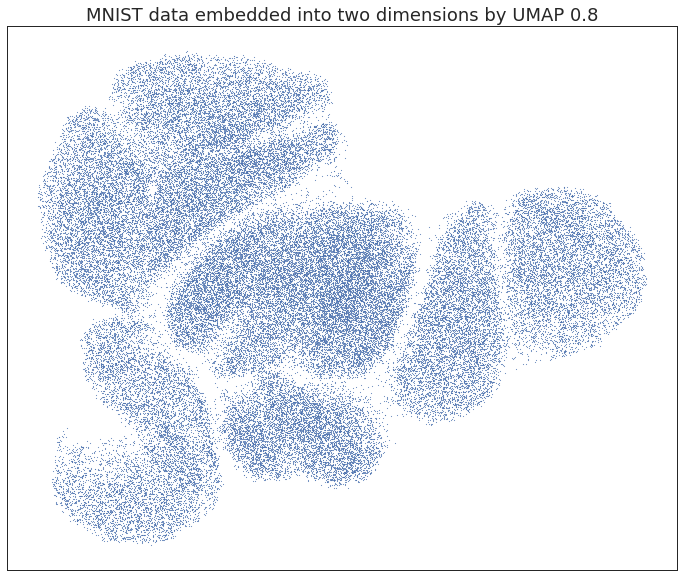

In [90]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="paper", style="white")

reducer = umap.UMAP(random_state=42,min_dist=0.8)
embedding = reducer.fit_transform(mnist.data)

fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(
#    embedding[:, 0], embedding[:, 1], c=mnist.target, cmap="Spectral", s=0.1
    embedding[:, 0], embedding[:, 1], cmap="Spectral", s=0.1
)
plt.setp(ax, xticks=[], yticks=[])
plt.title("MNIST data embedded into two dimensions by UMAP 0.8", fontsize=18)

plt